There are 2 additional steps to use DeepCTR with sequence feature input.

1. Generate the paded and encoded sequence feature of sequence input feature(value 0 is for padding).
2. Generate config of sequence feature with VarLenSparseFeat

In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences

from deepctr.models import DeepFM
from deepctr.feature_column import SparseFeat, VarLenSparseFeat, get_feature_names

In [4]:
def split(x):
    key_ans = x.split('|')
    for key in key_ans:
        if key not in key2index:
            # Notice : input value 0 is a special "padding",so we do not use 0 to encode valid feature for sequence input
            key2index[key] = len(key2index) + 1
    return list(map(lambda x: key2index[x], key_ans))

In [5]:
data = pd.read_csv("./data/movielens_sample.txt")

In [6]:
data.head(3)

,user_id,movie_id,rating,timestamp,title,genres,gender,age,occupation,zip
0,3299,235,4,968035345,Ed Wood (1994),Comedy|Drama,F,25,4,19119
1,3630,3256,3,966536874,Patriot Games (1992),Action|Thriller,M,18,4,77005
2,517,105,4,976203603,"Bridges of Madison County, The (1995)",Drama|Romance,F,25,14,55408


In [7]:
sparse_features = ["movie_id", "user_id",
                       "gender", "age", "occupation", "zip", ]
target = ['rating']

In [8]:
# Label Encoding for sparse features,and process sequence features
for feat in sparse_features:
    lbe = LabelEncoder()
    data[feat] = lbe.fit_transform(data[feat])

In [11]:
# preprocess the sequence feature
key2index = {}
genres_list = list(map(split, data['genres'].values))
genres_length = np.array(list(map(len, genres_list)))
max_len = max(genres_length)
# Notice : padding=`post`
genres_list = pad_sequences(genres_list, maxlen=max_len, padding='post', )

In [32]:
# Count #unique features for each sparse field and generate feature config for sequence feature
fixlen_feature_columns = [SparseFeat(feat, data[feat].max() + 1, embedding_dim=4)
                            for feat in sparse_features]

use_weighted_sequence = False
if use_weighted_sequence:
    varlen_feature_columns = [VarLenSparseFeat(SparseFeat('genres', vocabulary_size=len(
        key2index) + 1, embedding_dim=4), maxlen=max_len, combiner='mean',
                                                weight_name='genres_weight')]  # Notice : value 0 is for padding for sequence input feature
else:
    varlen_feature_columns = [VarLenSparseFeat(SparseFeat('genres', vocabulary_size=len(
        key2index) + 1, embedding_dim=4), maxlen=max_len, combiner='mean',
                                                weight_name=None)]  # Notice : value 0 is for padding for sequence input feature

linear_feature_columns = fixlen_feature_columns + varlen_feature_columns
dnn_feature_columns = fixlen_feature_columns + varlen_feature_columns

feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)

In [33]:
feature_names

['movie_id', 'user_id', 'gender', 'age', 'occupation', 'zip', 'genres']

In [34]:
# Generate input data for model
model_input = {name: data[name] for name in feature_names}
model_input["genres"] = genres_list
model_input["genres_weight"] = np.random.randn(data.shape[0], max_len, 1)

In [35]:
# Define Model,compile and train
model = DeepFM(linear_feature_columns, dnn_feature_columns, task='regression')

model.compile("adam", "mse", metrics=['mse'], )
history = model.fit(model_input, data[target].values,
                    batch_size=256, epochs=100, verbose=2, validation_split=0.2, )

Epoch 1/100
1/1 - 3s - loss: 14.2999 - mse: 14.2999 - val_loss: 13.3671 - val_mse: 13.3671
Epoch 2/100
1/1 - 0s - loss: 14.1421 - mse: 14.1421 - val_loss: 13.2099 - val_mse: 13.2099
Epoch 3/100
1/1 - 0s - loss: 13.9587 - mse: 13.9587 - val_loss: 13.0372 - val_mse: 13.0372
Epoch 4/100
1/1 - 0s - loss: 13.7573 - mse: 13.7573 - val_loss: 12.8463 - val_mse: 12.8463
Epoch 5/100
1/1 - 0s - loss: 13.5349 - mse: 13.5349 - val_loss: 12.6348 - val_mse: 12.6348
Epoch 6/100
1/1 - 0s - loss: 13.2897 - mse: 13.2897 - val_loss: 12.4004 - val_mse: 12.4004
Epoch 7/100
1/1 - 0s - loss: 13.0187 - mse: 13.0187 - val_loss: 12.1410 - val_mse: 12.1410
Epoch 8/100
1/1 - 0s - loss: 12.7188 - mse: 12.7188 - val_loss: 11.8542 - val_mse: 11.8542
Epoch 9/100
1/1 - 0s - loss: 12.3869 - mse: 12.3869 - val_loss: 11.5370 - val_mse: 11.5370
Epoch 10/100
1/1 - 0s - loss: 12.0199 - mse: 12.0199 - val_loss: 11.1866 - val_mse: 11.1866
Epoch 11/100
1/1 - 0s - loss: 11.6143 - mse: 11.6143 - val_loss: 10.8007 - val_mse: 10.80

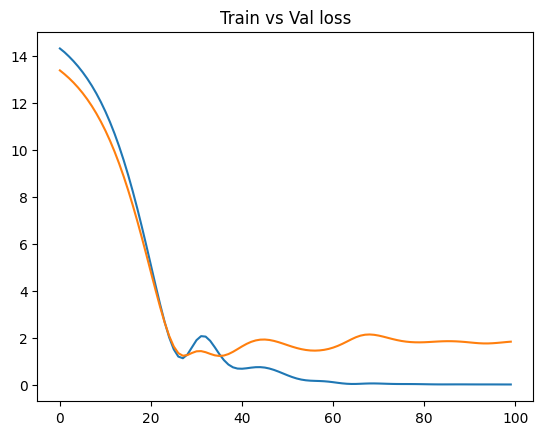

In [36]:
# 
import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(train_loss)
plt.plot(val_loss)

plt.title("Train vs Val loss");